In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import geopandas as gpd
import folium 
!pip install mapclassify

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor  
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

from time import time

from warnings import simplefilter
simplefilter("ignore")
import geopandas as gpd
print(gpd.__version__)

data = pd.read_csv('/Users/zohaibjamil/Documents/Simon MSBA/Fall A/Prof Comm/Round 4/archive (4)/AB_NYC_2019.csv')

data.head()


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
1.0.1


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [32]:
print(f'The dataset has {data.shape[0]} rows and {data.shape[1]} columns.')


The dataset has 48895 rows and 16 columns.


In [33]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [34]:
data.isnull().sum()


id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [35]:
data2 = data.copy()
data2.dropna(inplace=True)

print(f'After removing the nulls, there are {data2.host_id.nunique()} host IDs and {data2.host_name.nunique()} host names.')
print("There is no one-to-one correspondence between 'host_id' and 'host_name'.")

After removing the nulls, there are 30232 host IDs and 9885 host names.
There is no one-to-one correspondence between 'host_id' and 'host_name'.


In [36]:
data2.drop(['id','host_name','last_review'],axis=1,inplace=True)

data2.head()

,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Skylit Midtown Castle,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
3,Cozy Entire Floor of Brownstone,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Entire Apt: Spacious Studio/Loft by central park,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0
5,Large Cozy 1 BR Apartment In Midtown East,7322,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,0.59,1,129


In [37]:
data2.rename(columns={'neighbourhood_group':'borough'},inplace=True)

In [38]:
print(f'There are {data2.borough.nunique()} boroughs in NYC. The data contains info about {data2.neighbourhood.nunique()} neighbourhoods.')

print(f'Neighbourhoods are subparts of the {data2.borough.nunique()} larger boroughs.')

There are 5 boroughs in NYC. The data contains info about 218 neighbourhoods.
Neighbourhoods are subparts of the 5 larger boroughs.


In [39]:
data2.groupby(['borough','neighbourhood'])['neighbourhood'].count().reset_index(name='apt. count').sort_values('apt. count',ascending=False).head(10)


,borough,neighbourhood,apt. count
93,Brooklyn,Williamsburg,3163
50,Brooklyn,Bedford-Stuyvesant,3141
105,Manhattan,Harlem,2204
58,Brooklyn,Bushwick,1942
106,Manhattan,Hell's Kitchen,1528
100,Manhattan,East Village,1489
124,Manhattan,Upper West Side,1482
123,Manhattan,Upper East Side,1405
65,Brooklyn,Crown Heights,1265
112,Manhattan,Midtown,986


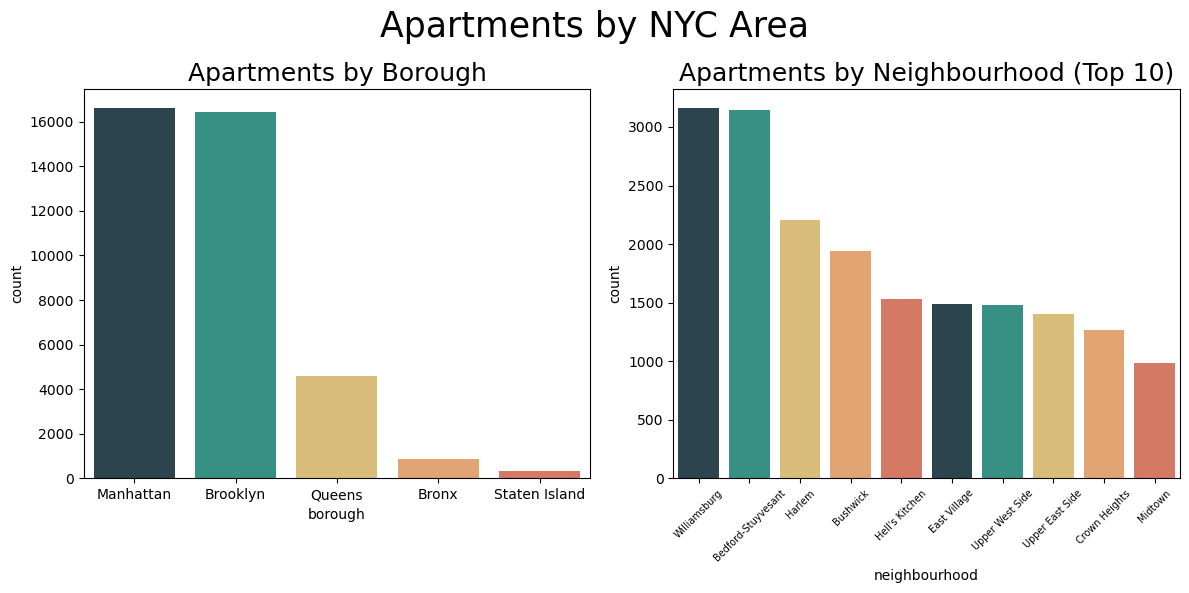

In [40]:
# Professional color palette with a combination of colors
palette = sns.color_palette(["#264653", "#2A9D8F", "#E9C46A", "#F4A261", "#E76F51"])

# Group and sort data
neighbourhood_group = data2.groupby('borough')['borough'].count().reset_index(name='count').sort_values('count', ascending=False)
neighbourhood = data2.groupby('neighbourhood')['neighbourhood'].count().reset_index(name='count').sort_values('count', ascending=False)

# Create subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

# Barplot for boroughs
sns.barplot(data=neighbourhood_group, x='borough', y='count', palette=palette, ax=ax1)
ax1.set_title('Apartments by Borough', size=18)

# Barplot for neighbourhoods
sns.barplot(data=neighbourhood.head(10), x='neighbourhood', y='count', palette=palette, ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=7)
ax2.set_title('Apartments by Neighbourhood (Top 10)', size=18)

# Add a super title
plt.suptitle('Apartments by NYC Area', size=25)

# Adjust layout
plt.tight_layout()

plt.show()


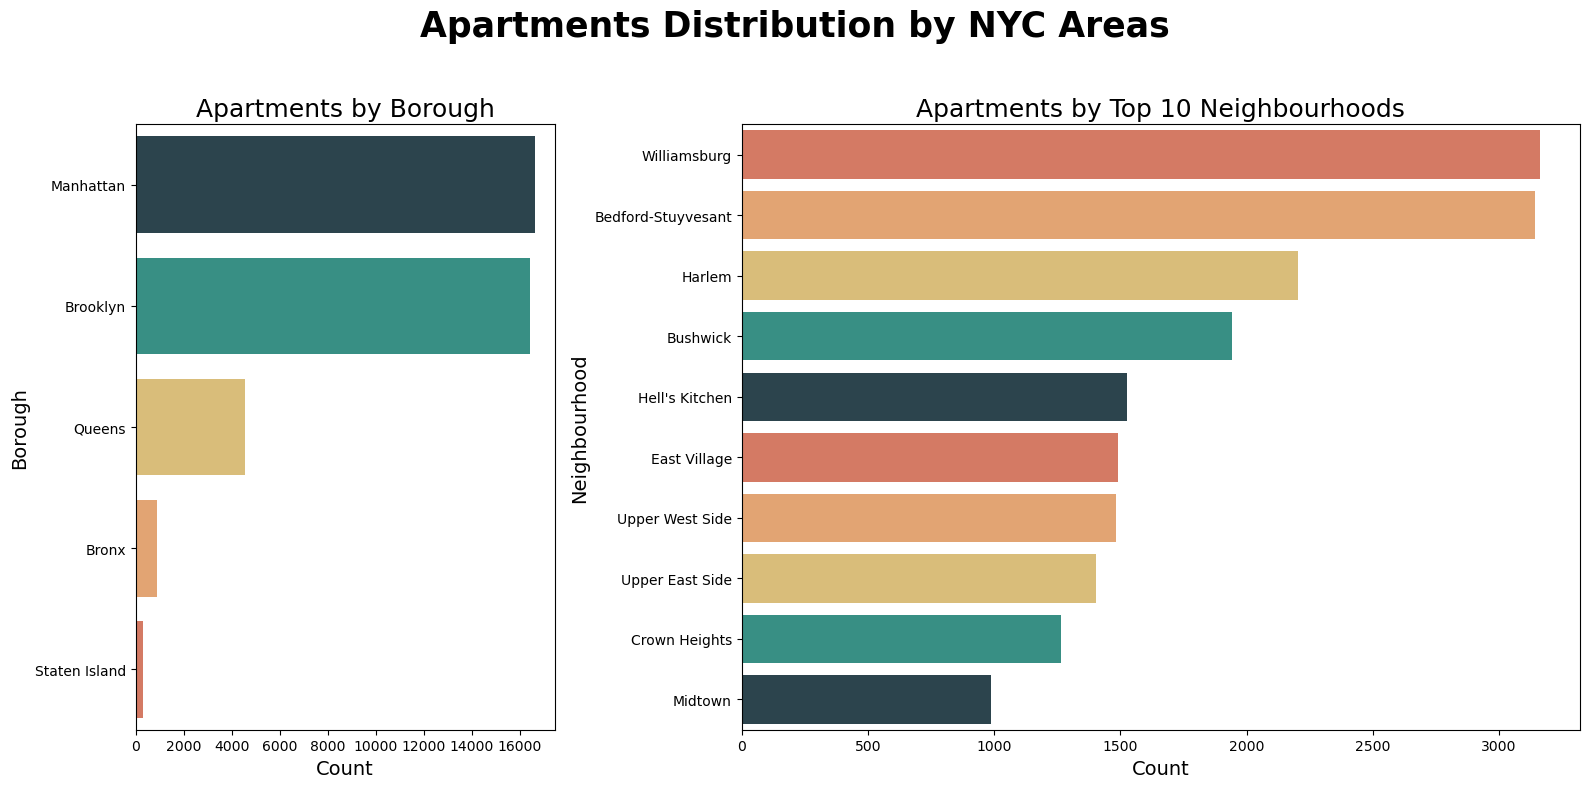

In [41]:
# Create subplots with adjusted layout for better visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [1, 2]})

# Define the saved color palette
palette = ["#264653", "#2A9D8F", "#E9C46A", "#F4A261", "#E76F51"]

# Horizontal bar plot for boroughs to better compare counts
sns.barplot(data=neighbourhood_group, y='borough', x='count', palette=palette, ax=axes[0])
axes[0].set_title('Apartments by Borough', size=18)
axes[0].set_xlabel('Count', size=14)
axes[0].set_ylabel('Borough', size=14)

# Treemap-like horizontal bar plot for top 10 neighborhoods
sns.barplot(data=neighbourhood.head(10), y='neighbourhood', x='count', palette=palette[::-1], ax=axes[1])
axes[1].set_title('Apartments by Top 10 Neighbourhoods', size=18)
axes[1].set_xlabel('Count', size=14)
axes[1].set_ylabel('Neighbourhood', size=14)

# Add a central title for the entire visualization
plt.suptitle('Apartments Distribution by NYC Areas', size=25, weight='bold')

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()


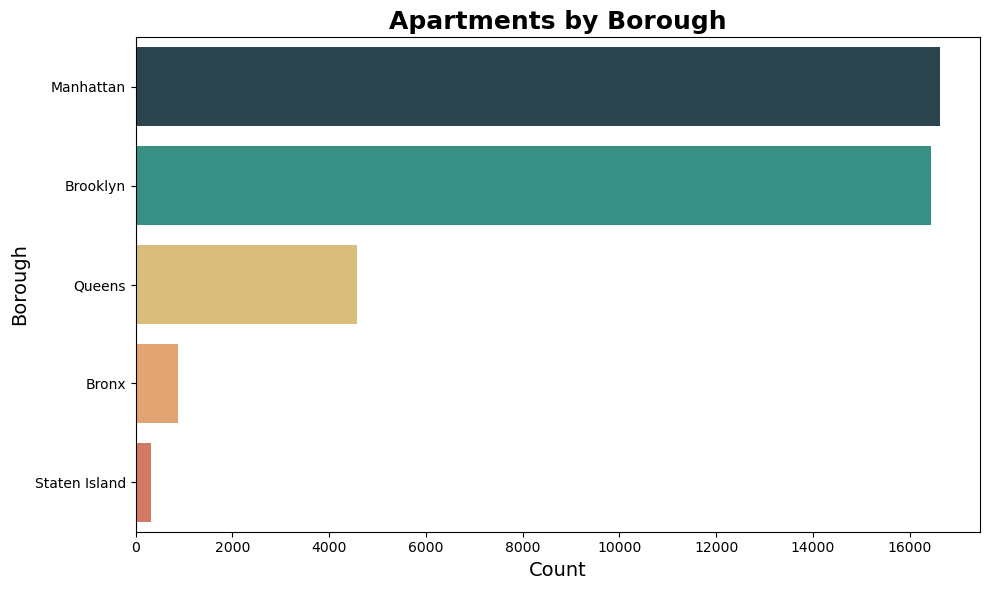

In [42]:
# Visualization for Apartments by Borough
fig, ax = plt.subplots(figsize=(10, 6))

# Horizontal bar plot for boroughs
sns.barplot(data=neighbourhood_group, y='borough', x='count', palette=["#264653", "#2A9D8F", "#E9C46A", "#F4A261", "#E76F51"], ax=ax)
ax.set_title('Apartments by Borough', size=18, weight='bold')
ax.set_xlabel('Count', size=14)
ax.set_ylabel('Borough', size=14)

plt.tight_layout()
plt.show()


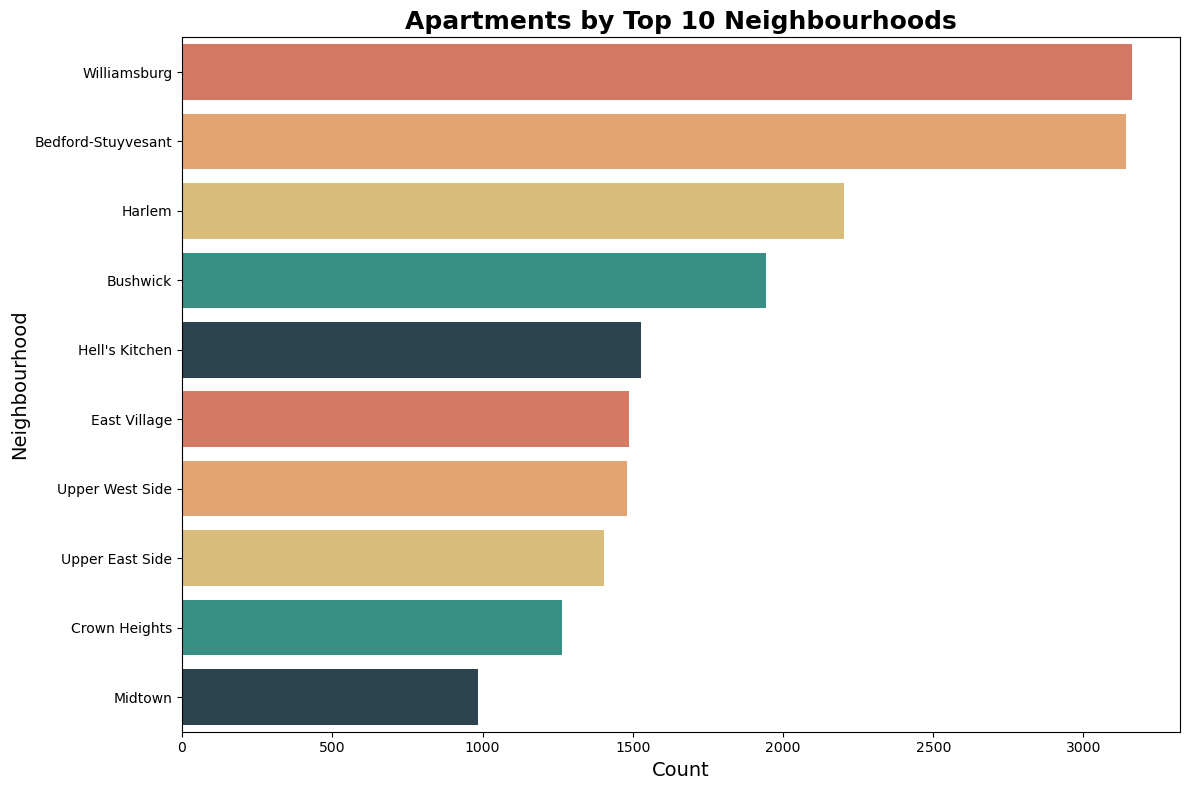

In [43]:
# Visualization for Apartments by Top 10 Neighbourhoods
fig, ax = plt.subplots(figsize=(12, 8))

# Horizontal bar plot for top 10 neighborhoods
sns.barplot(data=neighbourhood.head(10), y='neighbourhood', x='count', palette=["#E76F51", "#F4A261", "#E9C46A", "#2A9D8F", "#264653"], ax=ax)
ax.set_title('Apartments by Top 10 Neighbourhoods', size=18, weight='bold')
ax.set_xlabel('Count', size=14)
ax.set_ylabel('Neighbourhood', size=14)

plt.tight_layout()
plt.show()


In [44]:
# gpd.GeoDataFrame(
#     data2,geometry=gpd.points_from_xy(data2["longitude"],data2["latitude"]),crs="epsg:4386"
# ).explore(width=1000,height=600,name="correct")

In [45]:
room_type = data2.groupby('room_type')['room_type'].count().reset_index(name='count').sort_values('count',ascending=False)

room_type_borough = data2.groupby(['room_type','borough'])['room_type'].count().reset_index(name='count').sort_values('count',ascending=False)

room_type_price = data2.groupby('room_type')['price'].mean().reset_index(name='mean price').sort_values('mean price',ascending=False)

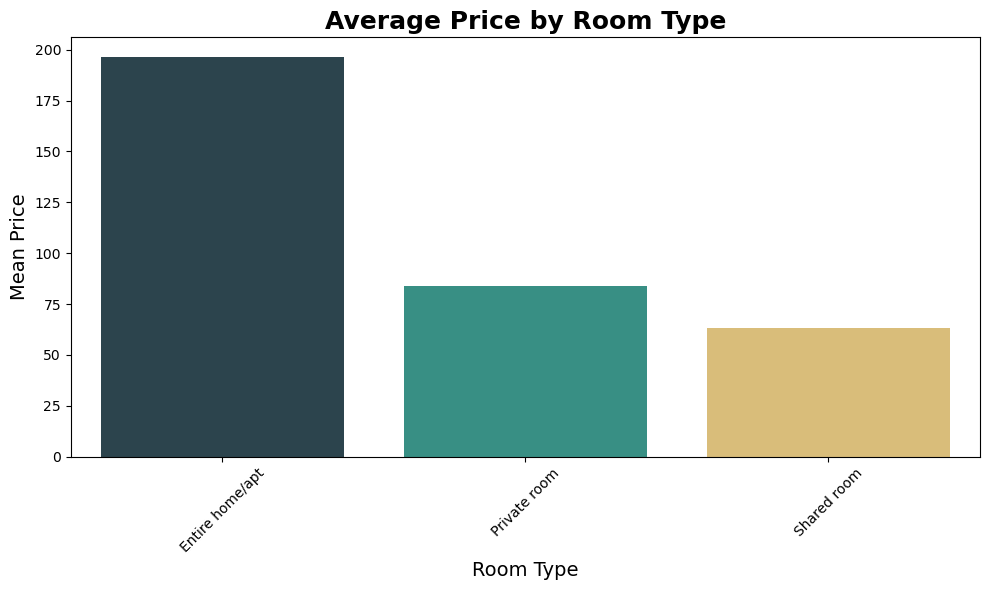

In [46]:
# Visualization 3: Average Price by Room Type
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(data=room_type_price, x='room_type', y='mean price', palette=["#264653", "#2A9D8F", "#E9C46A", "#F4A261", "#E76F51"], ax=ax)
ax.set_title('Average Price by Room Type', size=18, weight='bold')
ax.set_xlabel('Room Type', size=14)
ax.set_ylabel('Mean Price', size=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=10)

plt.tight_layout()
plt.show()


In [47]:
neighbourhood_list = neighbourhood.loc[neighbourhood['count'] > 20]['neighbourhood'].to_list()

minimum_nights_neighbourhood2 = data2.loc[data2.neighbourhood.isin(neighbourhood_list)].groupby('neighbourhood')['minimum_nights'].mean().reset_index(name='avg no. of minimum nights').sort_values('avg no. of minimum nights',ascending=False)

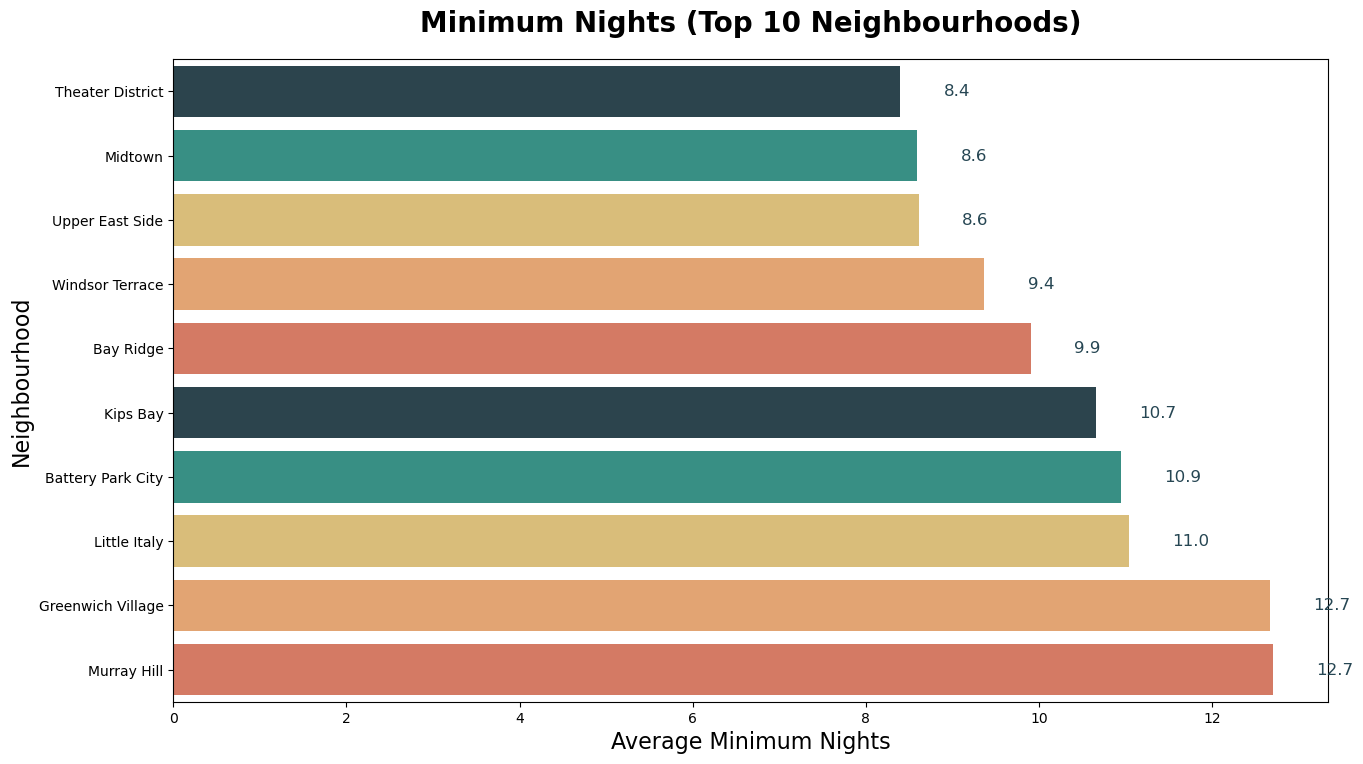

In [48]:
# Enhanced Visualization: Minimum Nights (Top 10 Neighbourhoods)
fig, ax = plt.subplots(figsize=(14, 8))

# Sort neighborhoods by average minimum nights for a better visual flow
data = minimum_nights_neighbourhood2.head(10).sort_values('avg no. of minimum nights', ascending=True)

sns.barplot(data=data, x='avg no. of minimum nights', y='neighbourhood', palette=["#264653", "#2A9D8F", "#E9C46A", "#F4A261", "#E76F51"], ax=ax, orient='h')
ax.set_title('Minimum Nights (Top 10 Neighbourhoods)', size=20, weight='bold', pad=20)
ax.set_xlabel('Average Minimum Nights', size=16)
ax.set_ylabel('Neighbourhood', size=16)

# Annotate bars with values
for i, (value, name) in enumerate(zip(data['avg no. of minimum nights'], data['neighbourhood'])):
    ax.text(value + 0.5, i, f"{value:.1f}", va='center', fontsize=12, color="#264653")

plt.tight_layout(pad=2)
plt.show()


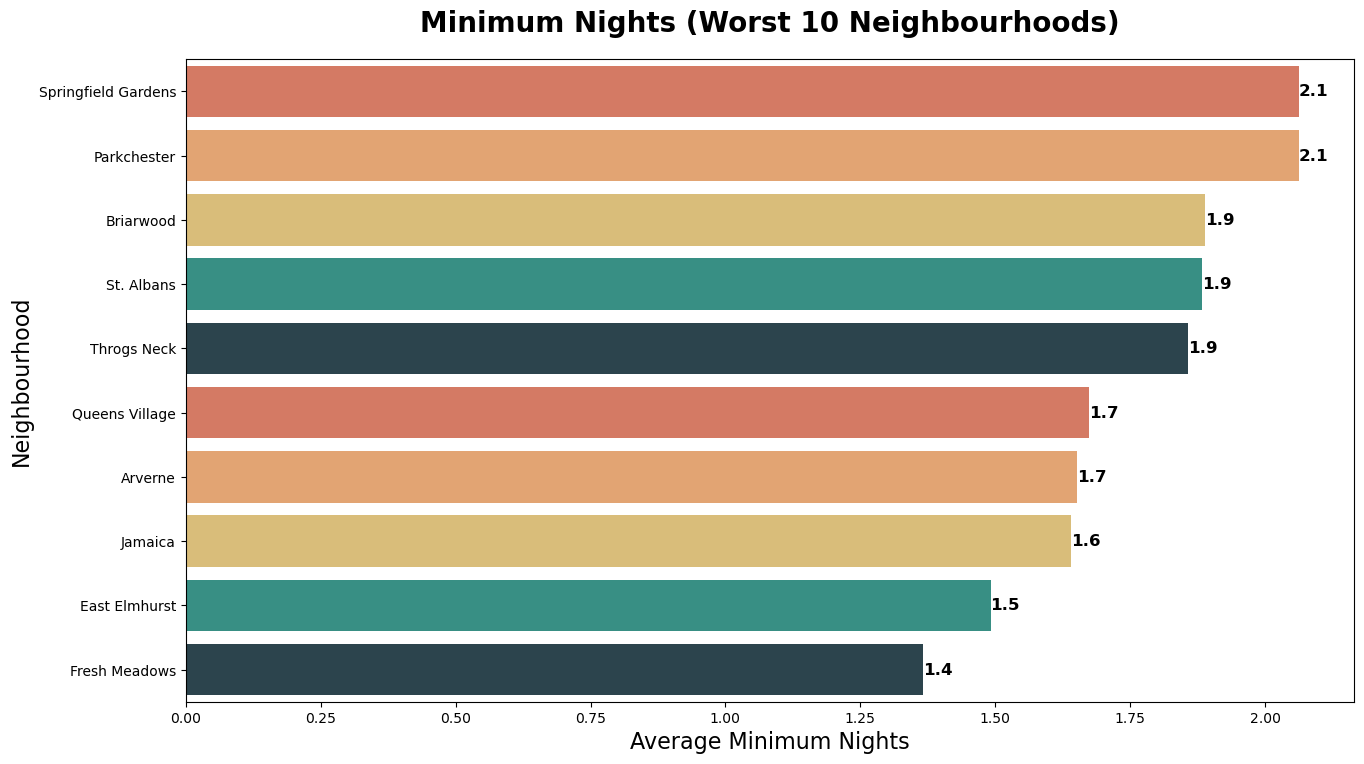

In [49]:
# Enhanced Visualization: Minimum Nights (Worst Neighbourhoods)
fig, ax = plt.subplots(figsize=(14, 8))

# Sort neighborhoods by average minimum nights for a better visual flow
data = minimum_nights_neighbourhood2.tail(10).sort_values('avg no. of minimum nights', ascending=False)

sns.barplot(data=data, x='avg no. of minimum nights', y='neighbourhood', palette=["#E76F51", "#F4A261", "#E9C46A", "#2A9D8F", "#264653"], ax=ax, orient='h')
ax.set_title('Minimum Nights (Worst 10 Neighbourhoods)', size=20, weight='bold', pad=20)
ax.set_xlabel('Average Minimum Nights', size=16)
ax.set_ylabel('Neighbourhood', size=16)

# Annotate bars with properly aligned numeric labels
for i, value in enumerate(data['avg no. of minimum nights']):
    ax.text(value, i, f"{value:.1f}", va='center', ha='left', fontsize=12, color="#000000", weight='bold')

plt.tight_layout(pad=2)
plt.show()


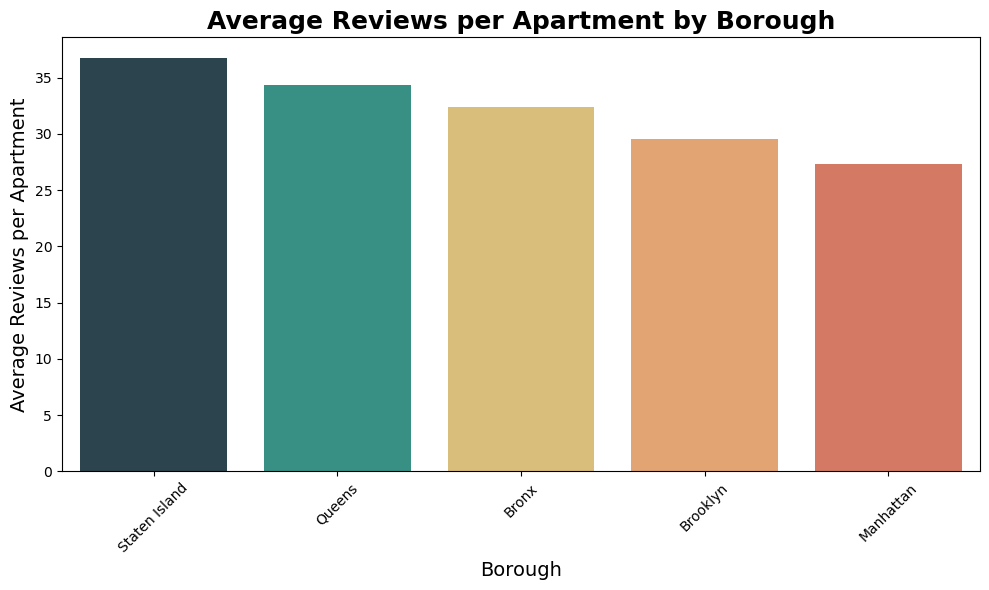

In [50]:


reviews_per_borough = data2.groupby('borough')['number_of_reviews'].sum().reset_index(name='total review count')

avg_reviews_borough = data2.groupby('borough')['number_of_reviews'].mean().reset_index(name='avg reviews/apartment')

reviews_per_borough = reviews_per_borough.merge(avg_reviews_borough,on='borough').sort_values('avg reviews/apartment',ascending=False)

reviews_per_borough

# Bar Chart: Average Reviews per Apartment by Borough
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(data=reviews_per_borough, x='borough', y='avg reviews/apartment', palette=["#264653", "#2A9D8F", "#E9C46A", "#F4A261", "#E76F51"], ax=ax)
ax.set_title('Average Reviews per Apartment by Borough', size=18, weight='bold')
ax.set_xlabel('Borough', size=14)
ax.set_ylabel('Average Reviews per Apartment', size=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=10)

plt.tight_layout()
plt.show()


In [51]:
# Rename the column 'neighbourhood_group' to 'borough'
data.rename(columns={'neighbourhood_group': 'borough'}, inplace=True)

# Verify the column name change
data.head()


,neighbourhood,avg no. of minimum nights
99,Springfield Gardens,2.062500
82,Parkchester,2.062500
10,Briarwood,1.888889
100,St. Albans,1.884058
107,Throgs Neck,1.857143


In [52]:
data2.head()

,name,host_id,borough,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Skylit Midtown Castle,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
3,Cozy Entire Floor of Brownstone,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Entire Apt: Spacious Studio/Loft by central park,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0
5,Large Cozy 1 BR Apartment In Midtown East,7322,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,0.59,1,129


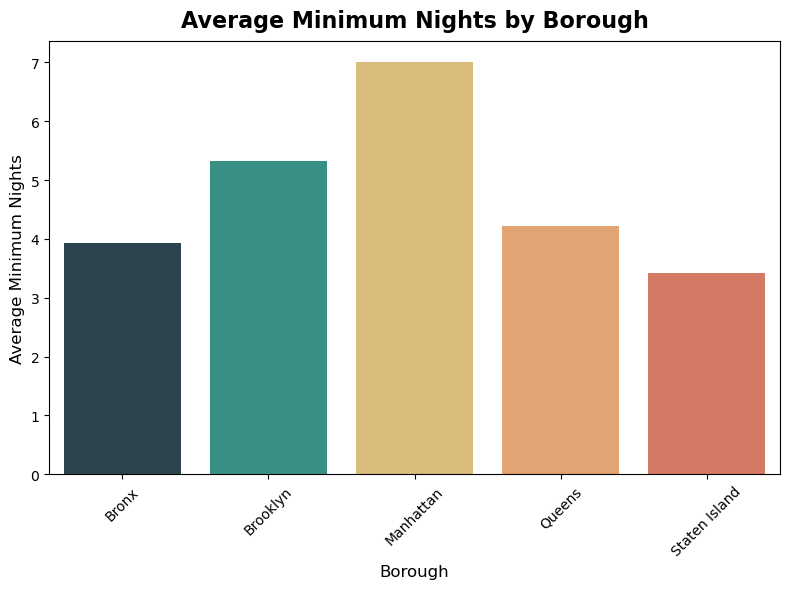

In [53]:
# Calculate the average minimum nights for each borough
avg_minimum_nights_borough = data2.groupby('borough')['minimum_nights'].mean().reset_index(name='avg minimum nights')

# Visualization: Average Minimum Nights by Borough (No Grid Lines)
fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(data=avg_minimum_nights_borough, x='borough', y='avg minimum nights',
            palette=["#264653", "#2A9D8F", "#E9C46A", "#F4A261", "#E76F51"], ax=ax)
ax.set_title('Average Minimum Nights by Borough', size=16, weight='bold', pad=10)
ax.set_xlabel('Borough', size=12)
ax.set_ylabel('Average Minimum Nights', size=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=10)

# Remove grid lines
ax.grid(False)

plt.tight_layout()
plt.show()


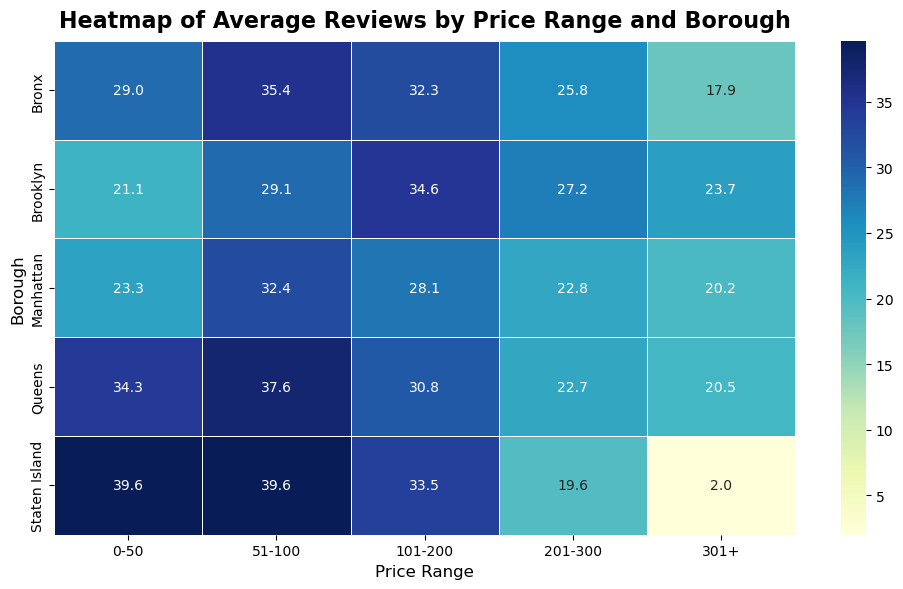

In [54]:
# Re-importing necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Reapply necessary transformations
price_bins = [0, 50, 100, 200, 300, float('inf')]
price_labels = ['0-50', '51-100', '101-200', '201-300', '301+']
data2['price_range'] = pd.cut(data2['price'], bins=price_bins, labels=price_labels, right=False)

# Calculate the average reviews for each price range
avg_reviews_by_price_range = data2.groupby(['borough', 'price_range'])['number_of_reviews'].mean().unstack(fill_value=0)

# Visualization: Heatmap of Average Reviews by Price Range
fig, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(avg_reviews_by_price_range, annot=True, fmt='.1f', cmap="YlGnBu", linewidths=.5, ax=ax)
ax.set_title('Heatmap of Average Reviews by Price Range and Borough', size=16, weight='bold', pad=10)
ax.set_xlabel('Price Range', size=12)
ax.set_ylabel('Borough', size=12)

plt.tight_layout()
plt.show()



In [55]:
# # Calculate percentages properly and ensure indices align
# room_distribution['percent'] = (
#     room_distribution['count'] / room_distribution.groupby('neighbourhood')['count'].transform('sum')
# ) * 100

# # Visualization: Room Distribution in Top 5 Neighbourhoods of Staten Island (Bold Title and Percentage Labels)
# fig, ax = plt.subplots(figsize=(12, 8))

# sns.barplot(data=room_distribution, x='neighbourhood', y='count', hue='room_type',
#             palette=["#264653", "#2A9D8F", "#E9C46A"], ax=ax)

# # Update title formatting
# ax.set_title('Room Distribution in Top 5 Neighbourhoods of Staten Island', size=16, weight='bold', pad=10)
# ax.set_xlabel('Neighbourhood', size=12)
# ax.set_ylabel('Number of Rooms', size=12)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=10)

# # Add percentage labels on bars
# for container in ax.containers:
#     # Add percentage labels for each bar
#     for bar in container:
#         height = bar.get_height()
#         if height > 0:
#             ax.text(
#                 bar.get_x() + bar.get_width() / 2,
#                 height,
#                 f'{height / sum([b.get_height() for b in container]):.1%}',
#                 ha='center',
#                 va='bottom',
#                 fontsize=10
#             )

# # Remove grid lines
# ax.grid(False)

# plt.tight_layout()
# plt.show()
